In [1]:
import numpy as np
import multiprocessing as mp
import subprocess
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

from astropy.time import Time

import sys
sys.path.append("..")

import rascals
rascals.setupOorb()
from rascals import Config
from rascals import calcNight
from rascals import convertMPCToOorb
from rascals import propagateOrbits
from rascals import generateEphemeris

In [2]:
# UTC - 3
# Sunset in Cerro Pachon in June ~ 6 PM
# Sunrise in Cerro Pachon in June ~ 7:30 AM

surveyCenter=[200, -10]
surveyShape=[60, 20]
mjdStart=59740
numNight=30

def prepareSurvey(surveyCenter,
                  surveyShape,
                  mjdStart,
                  numNights,
                  fieldType="square",
                  fieldArea=10,
                  fieldOverlap=0,
                  coveragePerNight=0.5,
                  localTime=3/24,
                  nightStart=19.5, 
                  hoursPerNight=10,
                  secondsBetweenExposures=60,
                  plotFootprint=True):
    
    if fieldType == "square":
        # Calculate field width and height in x and y
        xField = np.sqrt(fieldArea)
        yField = np.sqrt(fieldArea)

        # Create arrays with field centers
        xCenters = np.linspace(surveyCenter[0] - (surveyShape[0] / 2) * (xField - fieldOverlap/2) + xField/2, 
                               surveyCenter[0] + (surveyShape[0] / 2) * (xField - fieldOverlap/2) - xField/2, 
                               surveyShape[0])
        yCenters = np.linspace(surveyCenter[1] - (surveyShape[1] / 2) * (yField - fieldOverlap/2) + yField/2, 
                               surveyCenter[1] + (surveyShape[1] / 2) * (yField - fieldOverlap/2) - yField/2, 
                               surveyShape[1])
        # Create meshgrid with centers
        x, y = np.meshgrid(xCenters, yCenters)

        # Create a more logical "snake" pointing sequence 
        # preferentially moving up and down in y before moving
        # in x
        xPointings = x.flatten(order="F")
        yPointingsTemp = np.flip(y, 0).flatten(order="F")
        yPointings = np.zeros(len(xPointings))
        
        for i in range(surveyShape[0]):
            if i % 2 == 0:
                yPointings[i * surveyShape[1] : (i + 1) * surveyShape[1]] = yPointingsTemp[i * surveyShape[1] : (i + 1) * surveyShape[1]]
            else:
                yPointings[i * surveyShape[1] : (i + 1) * surveyShape[1]] = np.flip(yPointingsTemp[i * surveyShape[1] : (i + 1) * surveyShape[1]], 0)
        
        # Plot footprint
        if plotFootprint is True:
            fig, ax = plt.subplots(1, 1, dpi=200)
            ax.set_xlabel("RA")
            ax.set_ylabel("Dec")
            for xx, yy in zip(x.flatten(), y.flatten()):
                ax.add_patch(patches.Rectangle((xx-xField/2, yy-yField/2), xField, yField, fill=False, lw=0.5))
            ax.scatter(x.flatten(), y.flatten(), s=1)
            ax.plot(xPointings, yPointings)
            ax.set_aspect("equal")
    
    # Calculate total survey coverage
    surveyCoverage = (xCenters[-1] - xCenters[0] + xField) * (yCenters[-1] - yCenters[0] + yField)
    print("Survey coverage: {} square degrees".format(surveyCoverage))

    # Combine x pointing and y pointing arrays
    pointings = np.vstack([xPointings, yPointings]).T
    
    numExposuresPerNight = hoursPerNight * 60 / secondsBetweenExposures * 60
    delta_t = secondsBetweenExposures / (3600 * 24)
    print("Number of exposures per night: {}".format(numExposuresPerNight))
    
    field_ids = np.arange(1, len(pointings) + 1)
    visit_ids = np.arange(1, numExposuresPerNight * numNights + 1)
    print("Total number of exposures: {}".format(len(visit_ids)))
    
    exp_times = []
    for i in range(numNights):
        t_start = Time(mjdStart + i + localTime + (nightStart - 24) / 24, format="mjd", scale="utc").value
        times = t_start + np.arange(0, numExposuresPerNight) * delta_t
        exp_times.append(times)
        
    exp_times = np.hstack(exp_times)

    survey = np.zeros([len(visit_ids), 6])
    survey[:, 0] = visit_ids
    survey[:, 2] = exp_times
    survey[:, 3] = calcNight(exp_times)
    
    j = 0
    for i, p in enumerate(survey):
        if j == len(field_ids):
            j = 0
        
        survey[i, 1] = field_ids[j]
        survey[i, 4:6] = pointings[j, :]
        
        j += 1
    
    survey = pd.DataFrame.from_records(survey, columns=["visit_id", "field_id", "exp_mjd", "night", "field_ra", "field_dec"])
    survey = survey.astype({"visit_id": "int32", "field_id": "int32", "night": "int32"}, copy=False)
    return survey

Survey coverage: 12000.000000000002 square degrees
Number of exposures per night: 600.0
Total number of exposures: 18000


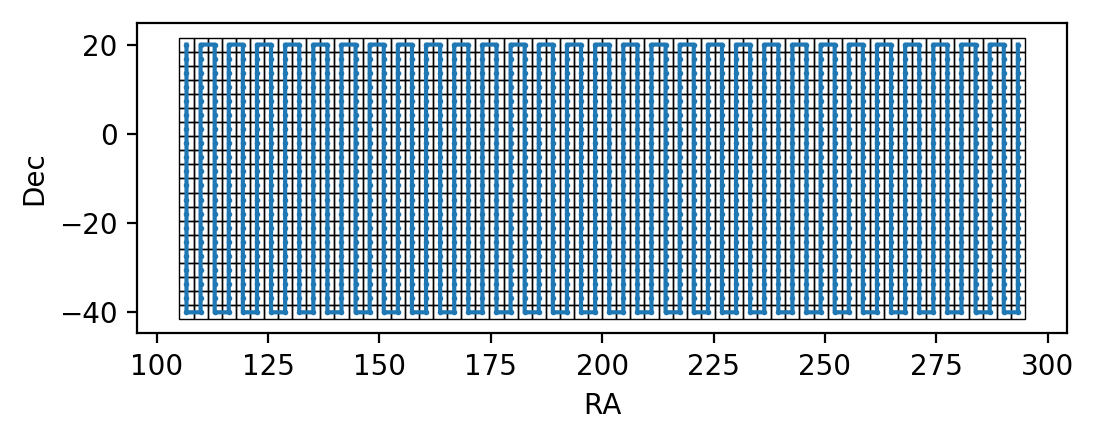

In [3]:
survey  = prepareSurvey(surveyCenter, surveyShape, mjdStart, numNight)

In [4]:
from rascals import findObsInCell
from matplotlib.patches import Rectangle

In [5]:
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
xx, yy = np.meshgrid(x, y)
xx = xx.flatten()
yy = yy.flatten()
ids = np.arange(0, len(xx))

# Randomly select some centers and areas
centers = np.random.choice(len(xx), size=5)
areas = np.random.rand(5) * 10

for center, area in zip(centers, areas):
    # Calculate distances and select those that should be inside
    ##distances = np.sqrt((xx - xx[center])**2 + (yy - yy[center])**2)
    inside = ids[np.where((np.abs(xx - xx[center]) <= np.sqrt(area) / 2) & (np.abs(yy - yy[center]) <= np.sqrt(area) / 2))[0]]
    np.testing.assert_array_equal(inside,
                                  findObsInCell(ids,
                                                np.array([xx, yy]).T,
                                                np.array([xx[center], yy[center]]),
                                                fieldArea=area,
                                                fieldShape="square"))

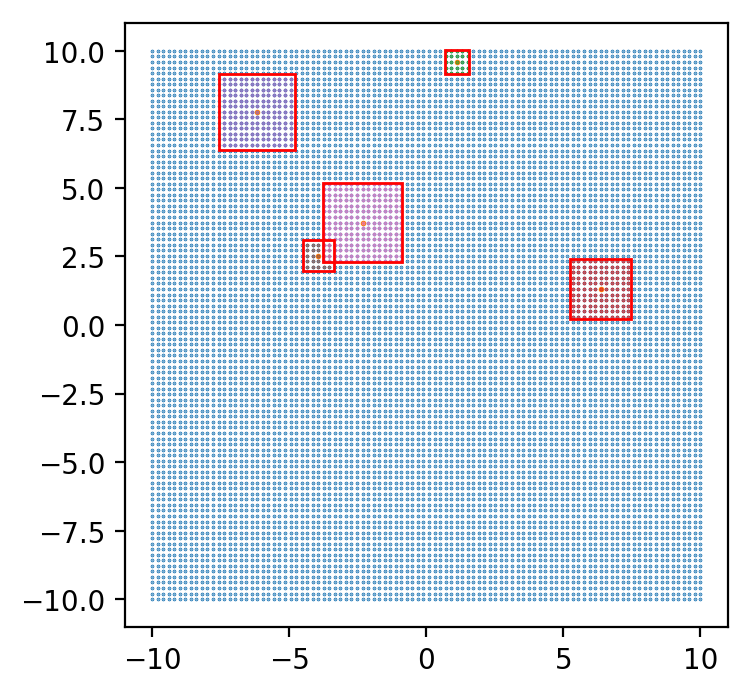

In [6]:
fig, ax = plt.subplots(1, 1, dpi=200)
ax.set_aspect("equal")
ax.scatter(xx, yy, s=0.1)
ax.scatter(xx[centers], yy[centers], s=1)

for center, area in zip(centers, areas):
    half_side = np.sqrt(area) / 2
    ax.add_patch(Rectangle((xx[center] - half_side, yy[center] - half_side), half_side*2, half_side*2,linewidth=1,edgecolor='r',facecolor='none'))
    mask = np.where((np.abs(xx - xx[center]) <= half_side) & (np.abs(yy - yy[center]) <= half_side))[0]
    ax.scatter(xx[mask], yy[mask], s=0.1)

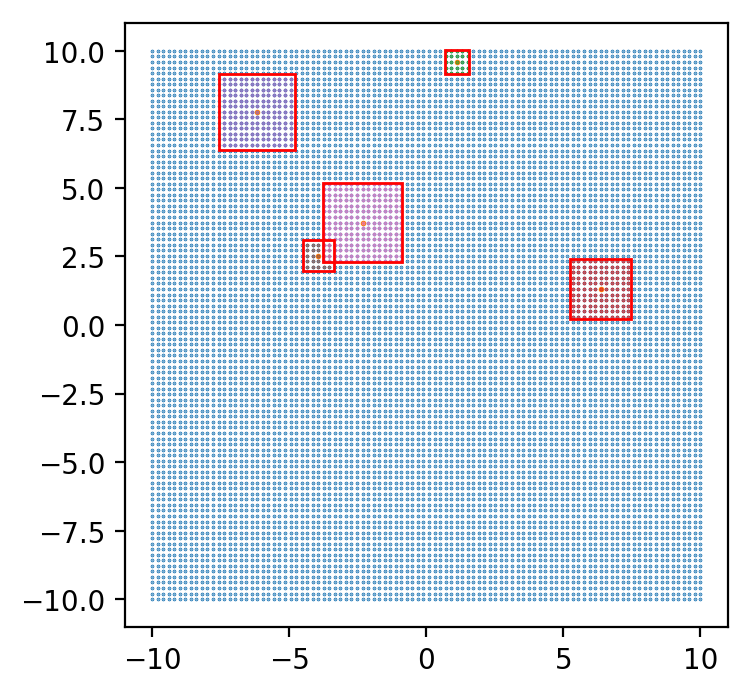

In [7]:
fig, ax = plt.subplots(1, 1, dpi=200)
ax.set_aspect("equal")
ax.scatter(xx, yy, s=0.1)
ax.scatter(xx[centers], yy[centers], s=1)

for center, area in zip(centers, areas):
    half_side = np.sqrt(area) / 2
    ax.add_patch(Rectangle((xx[center] - half_side, yy[center] - half_side), half_side*2, half_side*2,linewidth=1,edgecolor='r',facecolor='none'))
    
    inside = findObsInCell(ids,
                           np.array([xx, yy]).T,
                           np.array([xx[center], yy[center]]),
                           fieldArea=area,
                           fieldShape="square")
    ax.scatter(xx[inside], yy[inside], s=0.1)

In [8]:
mpcorbFile = "../data/MPCORB.DAT"
orbFileIn = "../data/MPCORB.orb"
orbFileOutStart = "../data/MPCORB_{}.orb".format(survey["night"].values[0])
orbFileOutEnd = "../data/MPCORB_{}.orb".format(survey["night"].values[-1])
ephFileStart = "../data/MPCORB_{}.eph".format(survey["night"].values[0])
ephFileEnd =  "../data/MPCORB_{}.eph".format(survey["night"].values[-1])

In [9]:
convertMPCToOorb(mpcorbFile, orbFileIn)

Converting ../data/MPCORB.DAT to ../data/MPCORB.orb...
Done.



In [10]:
propagateOrbits(orbFileIn, orbFileOutStart, survey["exp_mjd"].values[0])
generateEphemeris(orbFileOutStart, ephFileStart)

Propagating ../data/MPCORB.orb to 59739.9375...
Saving to ../data/MPCORB_59740.orb.
Done.

Generating ephemeris for I11 using ../data/MPCORB_59740.orb...
Saving to ../data/MPCORB_59740.eph.
Done.



In [12]:
propagateOrbits(orbFileIn, orbFileOutEnd, survey["exp_mjd"].values[-1])
generateEphemeris(orbFileOutEnd, ephFileEnd)

Propagating ../data/MPCORB.orb to 59769.353472222225...
Saving to ../data/MPCORB_59769.orb.
Done.

Generating ephemeris for I11 using ../data/MPCORB_59769.orb...
Saving to ../data/MPCORB_59769.eph.
Done.



In [13]:
from rascals import readORBFile

In [14]:
orb = readORBFile(orbFileOutStart)

In [15]:
duplicates = orb.groupby("designation").filter(lambda x: len(x) > 1)

In [16]:
duplicates["designation"].nunique()

1454

In [17]:
duplicates.to_csv("../data/duplicates.txt", sep=" ", index=False)

In [18]:
from rascals import readEPHFile

In [19]:
ephStart = readEPHFile(ephFileStart)

In [20]:
ephEnd = readEPHFile(ephFileEnd)

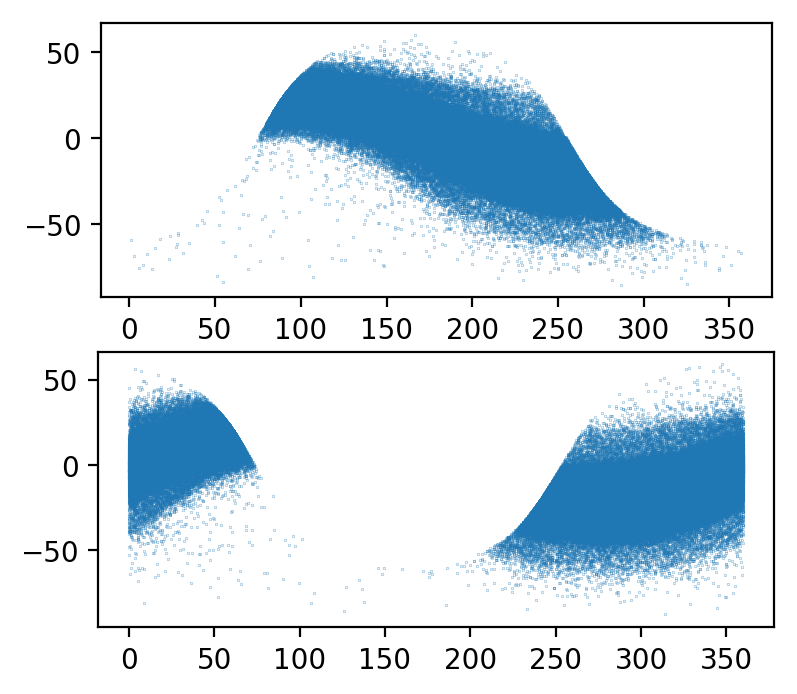

In [25]:
fig, ax = plt.subplots(2, 1, dpi=200)
ax[0].set_aspect("equal")
ax[0].scatter(*ephStart[ephStart["Alt_deg"] > 0][["RA_deg", "Dec_deg"]].values.T, s=0.01)
ax[1].set_aspect("equal")
ax[1].scatter(*ephEnd[ephEnd["Alt_deg"] > 0][["RA_deg", "Dec_deg"]].values.T, s=0.01)

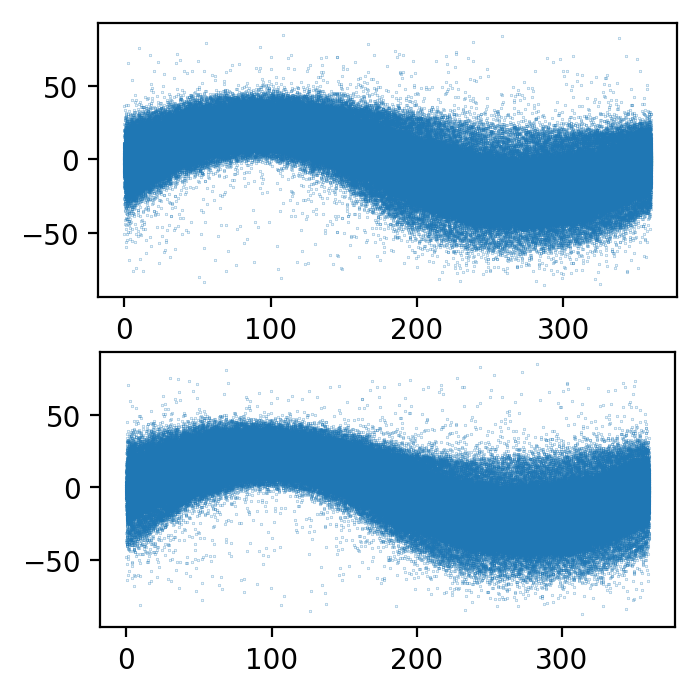

In [34]:
fig, ax = plt.subplots(2, 1, dpi=200)
ax[0].set_aspect("equal")
ax[0].scatter(*ephStart[["RA_deg", "Dec_deg"]].values.T, s=0.01)
ax[1].set_aspect("equal")
ax[1].scatter(*ephEnd[["RA_deg", "Dec_deg"]].values.T, s=0.01)

In [48]:
survey.iloc[0][['field_ra', 'field_dec']].values

array([ 106.71280903,   20.04163777])

In [53]:
ids = findObsInCell(ephEnd["obsId"].values, ephEnd[["RA_deg", "Dec_deg"]], survey.iloc[0][['field_ra', 'field_dec']].values)

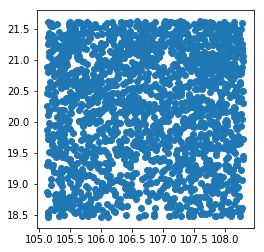

In [60]:
fig, ax = plt.subplots(1, 1)
ax.scatter(*ephEnd[ephEnd["obsId"].isin(ids)][["RA_deg", "Dec_deg"]].values.T)
ax.set_aspect("equal")

,designation,code,mjd_utc,Delta_au,RA_deg,Dec_deg,dDelta/dt_au_p_day,dRA/dt_deg_p_day,dDec/dt_deg_p_day,VMag,...,HEclObj_dX/dt_au_p_day,HEclObj_dY/dt_au_p_day,HEclObj_dZ/dt_au_p_day,HEclObsy_X_au,HEclObsy_Y_au,HEclObsy_Z_au,EccAnom,TrueAnom,PosAngle_deg,obsId
793,00794,I11,59769.353472,5.056671,106.486854,18.992450,-0.000172,0.273019,-0.026091,17.970187,...,-0.007023,-0.001521,0.000359,0.294448,-0.973106,0.000032,170.834909,173.242748,95.458967,793
823,00824,I11,59769.353472,4.189635,107.280815,18.899231,-0.000367,0.354046,-0.026991,16.169614,...,-0.008559,-0.002464,0.001037,0.294448,-0.973106,0.000032,182.914274,182.538274,94.359507,823
860,00861,I11,59769.353472,4.438654,105.539821,21.439382,-0.000371,0.332607,-0.018981,15.709212,...,-0.008628,-0.001636,0.001204,0.294448,-0.973106,0.000032,152.307730,154.931073,93.266197,860
1180,01181,I11,59769.353472,3.286215,107.565335,20.773949,0.001302,0.501679,-0.078416,15.661634,...,-0.012033,-0.001871,-0.001135,0.294448,-0.973106,0.000032,41.380764,49.494136,98.883840,1180
1649,01650,I11,59769.353472,3.788394,105.433690,20.667873,-0.001592,0.399684,-0.042235,16.806879,...,-0.009092,-0.003036,-0.000010,0.294448,-0.973106,0.000032,211.422343,206.853849,96.032048,1649
1738,01739,I11,59769.353472,3.555864,106.697934,20.124490,-0.000464,0.434248,-0.050271,17.710690,...,-0.009749,-0.002647,-0.000085,0.294448,-0.973106,0.000032,179.719423,179.752238,96.603511,1738
1819,01820,I11,59769.353472,3.596625,107.798770,20.175081,0.000929,0.423160,-0.040325,18.148839,...,-0.009577,-0.001617,0.000595,0.294448,-0.973106,0.000032,146.094533,152.320888,95.443514,1819
1942,01943,I11,59769.353472,2.525578,108.181976,18.920967,-0.003608,0.673704,-0.113750,18.910108,...,-0.011408,-0.007286,-0.001152,0.294448,-0.973106,0.000032,257.150741,243.083655,99.583553,1942
2534,02535,I11,59769.353472,3.081537,106.526551,20.424057,-0.000727,0.544676,-0.055443,16.469316,...,-0.011938,-0.003416,0.000293,0.294448,-0.973106,0.000032,344.378983,343.088632,95.812162,2534
3259,03260,I11,59769.353472,3.087586,108.160496,20.221539,-0.000893,0.538800,-0.082213,16.859779,...,-0.011557,-0.004349,-0.000848,0.294448,-0.973106,0.000032,321.869164,318.470812,98.675556,3259


In [20]:
import os
import multiprocessing

In [33]:
def _propThenEph(visitId, mjd, orbFileIn, surveyName, surveyDir):
    
        suffix = "_{}".format(visitId)
        orbFileOut = os.path.join(surveyDir, surveyName + suffix + ".orb")
        ephFileOut = os.path.join(surveyDir, surveyName + suffix + ".eph")

        propagateOrbits(orbFileIn, orbFileOut, mjd)
        generateEphemeris(orbFileOut, ephFileOut)
        return orbFileOut, ephFileOut
    

In [39]:
def generateSurvey(survey, orbFileIn, threads=20, surveyName="MSST", surveyDir="msst"):
    visit_ids = survey["visit_id"].values
    exp_times = survey["exp_mjd"].values
    survey_names = [surveyName for i in range(0, len(visit_ids))]
    survey_dirs = [surveyDir for i in range(0, len(visit_ids))]
    orb_file = [orbFileIn for i in range(0, len(visit_ids))]
    
    p = multiprocessing.Pool(threads)

    orbFiles, ephFiles = p.starmap(_propThenEph, zip(visit_ids, exp_times, orb_file, survey_names, survey_dirs)) 
    return orbFiles, ephFiles
        
    
    

In [61]:
survey["exp_mjd"].values[-1]

59769.353472222225

In [49]:
ephEnd["obsId"]=np.arange(0, len(ephEnd))

In [50]:
ephEnd

,designation,code,mjd_utc,Delta_au,RA_deg,Dec_deg,dDelta/dt_au_p_day,dRA/dt_deg_p_day,dDec/dt_deg_p_day,VMag,...,HEclObj_dX/dt_au_p_day,HEclObj_dY/dt_au_p_day,HEclObj_dZ/dt_au_p_day,HEclObsy_X_au,HEclObsy_Y_au,HEclObsy_Z_au,EccAnom,TrueAnom,PosAngle_deg,obsId
0,00001,I11,59769.353472,3.596839,116.276242,25.824405,0.000780,0.440055,-0.052930,8.515626,...,-0.009474,-0.005381,0.001577,0.294448,-0.973106,0.000032,325.862002,323.349110,96.858598,0
1,00002,I11,59769.353472,3.018309,64.172785,-1.652046,-0.010647,0.456259,-0.050507,9.488030,...,-0.010056,0.004945,-0.002574,0.294448,-0.973106,0.000032,297.576700,285.076284,96.316863,1
2,00003,I11,59769.353472,1.865689,348.552164,1.970196,-0.013842,0.097570,0.011593,9.503158,...,0.003307,0.010465,-0.002511,0.294448,-0.973106,0.000032,285.070951,270.194110,83.224119,2
3,00004,I11,59769.353472,1.457690,340.780667,-14.565503,-0.007952,0.012915,-0.080992,6.586409,...,0.008600,0.007894,-0.001282,0.294448,-0.973106,0.000032,57.480996,61.900757,170.939868,3
4,00005,I11,59769.353472,2.485995,354.241710,-4.184936,-0.013303,0.042803,-0.008413,12.173071,...,0.003207,0.008286,-0.000797,0.294448,-0.973106,0.000032,198.112986,194.960961,101.119970,4
5,00006,I11,59769.353472,2.868167,79.231193,13.044645,-0.003266,0.538467,0.041612,10.261396,...,-0.010915,0.006969,0.000521,0.294448,-0.973106,0.000032,38.645287,46.602981,85.581069,5
6,00007,I11,59769.353472,3.211449,148.516553,8.151033,0.010552,0.396394,-0.132867,10.911759,...,-0.005164,-0.009084,-0.000332,0.294448,-0.973106,0.000032,105.836902,118.318943,108.530646,6
7,00008,I11,59769.353472,2.306841,199.201227,-1.570469,0.012827,0.186082,-0.120363,11.272125,...,0.006728,-0.007261,-0.000381,0.294448,-0.973106,0.000032,186.633122,185.663487,122.895991,7
8,00009,I11,59769.353472,1.598416,303.684877,-26.525241,-0.003605,-0.217913,-0.084594,9.828982,...,0.008816,0.005100,-0.000624,0.294448,-0.973106,0.000032,224.588954,219.867653,248.783810,8
9,00010,I11,59769.353472,2.304617,210.992284,-16.272262,0.012471,0.133133,-0.013279,10.479210,...,0.008871,-0.006265,0.000483,0.294448,-0.973106,0.000032,359.581734,359.531616,95.695920,9


In [14]:
mpcorbFile = "../data/reducedSample/MPCORB.DAT"
orbFileIn = "../data/reducedSample/MPCORB.orb"
orbFileOut = "../data/reducedSample/MPCORB_{}.orb".format(survey["night"].values[0])
ephFile = "../data/reducedSample/MPCORB_{}.eph".format(survey["night"].values[0])

In [81]:
convertMPCToOorb(mpcorbFile, orbFileIn)

Converting ../data/reducedSample/MPCORB.DAT to ../data/reducedSample/MPCORB.orb...
Done.



In [82]:
propagateOrbits(orbFileIn, orbFileOut, survey["exp_mjd"].values[0])
generateEphemeris(orbFileOut, ephFileStart)

Propagating ../data/reducedSample/MPCORB.orb to 59739.9375...
Saving to ../data/reducedSample/MPCORB_59740.orb.
Done.

Generating ephemeris for I11 using ../data/reducedSample/MPCORB_59740.orb...
Saving to ../data/reducedSample/MPCORB_59740.eph.
Done.



In [10]:
from rascals import buildObjectDatabase

In [12]:
con = buildObjectDatabase("../data/reducedSample/objects.db", mpcorbFile=mpcorbFile, orbFile=orbFileIn, ephFile=ephFile)

Building mpcOrbitCat table...
Reading MPCORB file to database...
Creating index on object names...
Done.

Building oorbOrbitCat table...
Reading oorb orbit file to database...
Creating index on object names...
Done.

Building ephemeris table...
Reading oorb ephemeris file to database...
Creating index on object names...
Creating index on observation ids...
Creating index on nights...
Creating positional indexes...
Done.


In [18]:
df = pd.read_sql("""SELECT * FROM mpcOrbitCat""", con)

In [20]:
df

,designation,H,G,epoch_pf_TT,meanAnom_deg,argPeri_deg,ascNode_deg,i_deg,e,n_deg_p_day,...,numObs,numOppos,obsArc,rmsResid_arcsec,coarsePerturbers,precisePerturbers,compName,flags,readableDesignation,lastObsInOrbitSolution
0,00001,3.34,0.12,K1794,309.49412,73.02367,80.30888,10.59322,0.075607,0.214089,...,6680,114,1801-2017,0.60,M-v,30h,MPCLINUX,0000,(1) Ceres,20171104
1,00002,4.13,0.11,K1794,291.65136,309.99154,173.08718,34.83792,0.230597,0.213432,...,7910,108,1821-2017,0.58,M-v,28h,MPCLINUX,0000,(2) Pallas,20171005
2,00003,5.33,0.32,K1794,259.23491,248.20648,169.85828,12.98996,0.256853,0.226097,...,6902,104,1821-2017,0.59,M-v,38h,MPCLINUX,0000,(3) Juno,20171126
3,00004,3.20,0.32,K1794,292.71034,150.94297,103.83591,7.14002,0.089152,0.271547,...,6903,100,1821-2017,0.60,M-p,18h,MPCLINUX,0000,(4) Vesta,20170323
4,00005,6.85,0.15,K1794,139.06218,358.75689,141.58349,5.36794,0.191465,0.238766,...,2447,75,1845-2017,0.55,M-v,38h,MPCLINUX,0000,(5) Astraea,20171122
5,00006,5.71,0.24,K1794,289.56753,239.86057,138.64807,14.73750,0.202802,0.261011,...,5658,88,1848-2017,0.53,M-v,38h,MPCLINUX,0007,(6) Hebe,20171019
6,00007,5.51,0.15,K1794,339.84951,145.31450,259.56448,5.52317,0.231441,0.267459,...,4992,84,1848-2017,0.58,M-v,38h,MPCLINUX,0000,(7) Iris,20170719
7,00008,6.49,0.28,K1794,13.76136,285.31022,110.90088,5.88654,0.157029,0.301755,...,2358,85,1847-2017,0.64,M-v,38h,MPCLINUX,0000,(8) Flora,20171124
8,00009,6.28,0.17,K1794,116.70276,6.19939,68.91720,5.57497,0.122113,0.267215,...,2526,75,1849-2017,0.60,M-v,38h,MPCLINUX,0000,(9) Metis,20170623
9,00010,5.43,0.15,K1794,46.19231,312.03848,283.21829,3.83201,0.112691,0.177147,...,2984,89,1849-2017,0.57,M-v,38h,MPCLINUX,0000,(10) Hygiea,20171126
